In [26]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display
from typing import Tuple, List

# Anastasiia Stepanova
## BIG HW 1
#### Language:
To solve the problem, I will use Python.

____
# The idea:

#### The first step is "solve for x".
- Since $y(x)$ is known, lets use $X$ as linspace for determining the change of all other parameters such as velocity, radius of curvature, etc. as $v(x)$, $R(x)$...

#### The second step is "change of basis" from f(x) to f(t).
- After, use increment of trajectory length $d\sigma$ and velocity $v$ to determine the time, which was hold fot every step in our previous linspace of $x$.

#### The third step is "motors become real".
- The last step is adding the tangent acceleration into the solution and setting start and final velocities to zero, using the $a_\tau$ value.


# 1st step
## Solve R, V, $a_n$ for x.

1. Set the Number of steps for the calculations (N)
2. Find curvature radius as $\rho = \frac{\sqrt{(1+(y'_x)^2)^3}}{y''_x}$ using sympy. Find all the values for the $\rho_i$ using np and my function "translate value".
3. Find normal acceleration values with the formula: $a_n = \frac{V^2_{max}}{\rho}$. Translate the values for $a_{ni}$.
4. Accept that world is not perfect and consider the limitations for $a_n$. If the value $a_n$ from previous point (3) is bigger than $a_{n max}$, recalculate the values for V based on the function $V_i = \sqrt{a_{nmax} * \rho_i}$, else V equal $V_max$

In [81]:
N = 10000

theta_0_s, A_s, om_s, x_s, t_s, V_s, pho = sp.symbols('\\theta_0, A, om, x, t, V, \pho')

a_n_m = 6.0
a_t_m = 10.0

V_max = 1.5

theta_0 = 0.2
A = 1
om = 3

subs_values = [(theta_0_s, theta_0), (A_s, A), (om_s, om)]

From the Internet I found that $\rho = \frac{\sqrt{(1+(y'_x)^2)^3}}{y''_x}$
So, lets find $y'_x$ and $y"_x$

In [28]:
y_x_sp = A_s * sp.sin(om_s * x_s + theta_0_s)
y_x_sp_derivative = sp.diff(y_x_sp, x_s)
y_x_sp_2nd_derivative = sp.diff(y_x_sp_derivative, x_s)

In [29]:
rho_s = sp.sqrt((1 + (y_x_sp_derivative) ** 2) ** 3) / y_x_sp_2nd_derivative

a_n_s = V_max ** 2 / rho_s

In [30]:
def translate_value(sym_linspace: sp.symbols, linspace: np.linspace, value_sp_expr: sp.Expr,
                    optional_data: List[Tuple[sp.Symbol, np.ndarray]] = None,
                    optional_values: List[Tuple[sp.Symbol, float]] = None) -> np.ndarray:
    values = np.empty(shape=(linspace.size, 1), dtype=float)

    vals = [(k, v) for k, v in optional_values] if optional_values is not None else []

    tmp_expr = value_sp_expr.subs(vals)

    for i in range(linspace.shape[0]):
        # opt = [(k, v[i]) for k, v in optional_data] if optional_data is not None else []
        y = tmp_expr.subs([(sym_linspace, linspace[i])])
        try:
            y = float(y)
        except TypeError:
            y = 0
        values[i] = y

    return values

In [31]:
X = np.linspace(0, 4, N)
Y = translate_value(x_s, X, y_x_sp, optional_values=subs_values)
Y_dot = translate_value(x_s, X, y_x_sp_derivative, optional_values=subs_values)
Y_ddot = translate_value(x_s, X, y_x_sp_2nd_derivative, optional_values=subs_values)
R = translate_value(x_s, X, rho_s, optional_values=subs_values)
a_n_from_sp = translate_value(x_s, X, a_n_s, optional_values=subs_values)

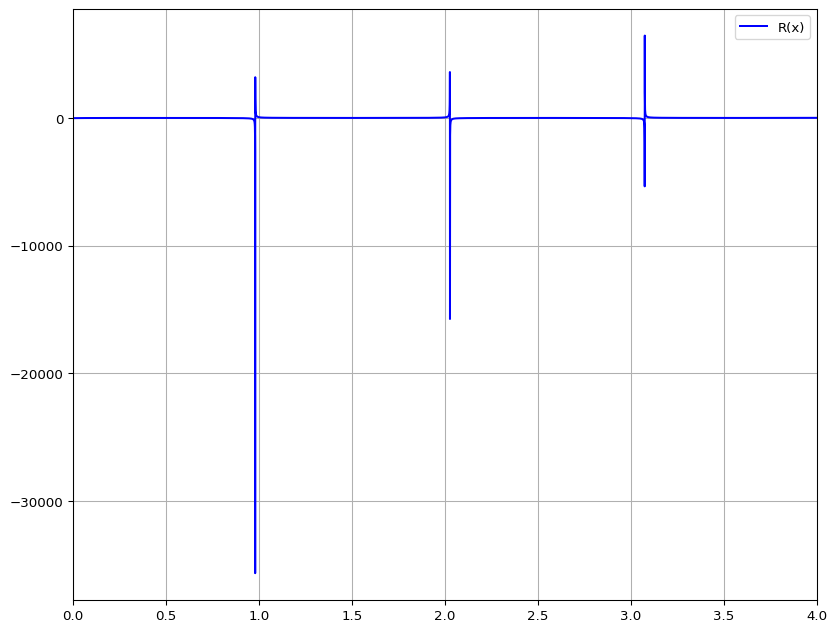

In [32]:
fig = plt.figure(figsize=(10, 8), dpi=96)

ax = plt.subplot()
ax.plot(X, R, 'b-', label='R(x)')
ax.legend()
ax.set_xlim(0, 4)
ax.grid()
plt.show()

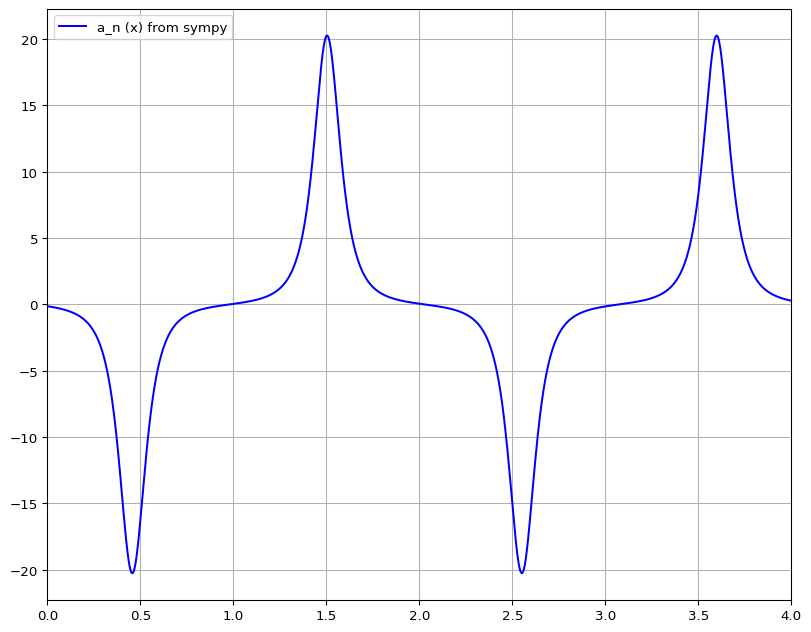

In [33]:
plt.figure(figsize=(10, 8), dpi=96)
ax = plt.subplot()
ax.plot(X, a_n_from_sp, 'b-', label='a_n (x) from sympy')
ax.legend()
ax.set_xlim(0, 4)
ax.grid()
plt.show()

Here we can see that for some $\rho$ values a_n_from_sp is bigger than $a_n max$, so use if operator to deal with that

In [34]:
a_n = []
V = []
i = 0
for a in a_n_from_sp:

    if np.abs(a) > a_n_m:
        a_n = np.abs(np.append(a_n, a_n_m))

    else:
        a_n = np.abs(np.append(a_n, a))
    V = np.append(V, np.sqrt(a_n[-1] * np.abs(R[i])))
    i += 1

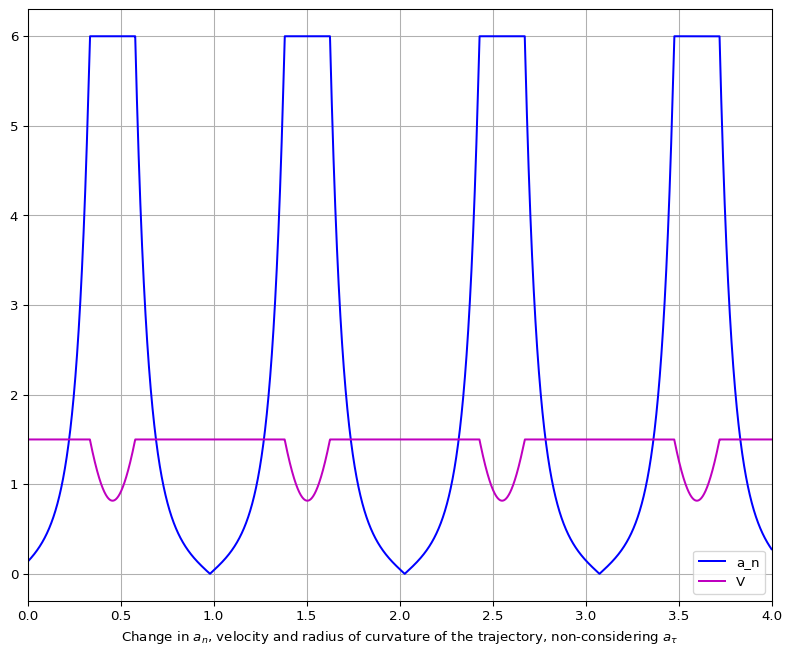

In [35]:
fig = plt.figure(figsize=(10, 8), dpi=96)

ax = plt.subplot()
ax.plot(X, a_n, 'b-', label='a_n')
ax.plot(X, V, 'm-', label='V')
ax.legend()
ax.set_xlim(0, 4)
ax.grid()
plt.xlabel('Change in $a_n$, velocity and radius of curvature of the trajectory, non-considering $a_\\tau$')
plt.show()

My calculations are correct and the car will drift on the trajectory.
# Step 2
Lets find the TIME!
____

1. Find the length of the trajectory on each point x: $\sigma_i = \sqrt{(x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2} + \sigma_{i-1}$
2. Find the time, spend to reach each point x based on $t = \frac{ds}{v}$ and plot the graph t(x)! Formula: $t_i = \frac{\sigma_{i+1} - \sigma_i}{v_i}$

In [36]:
def find_sigma(x: np.array, y: np.array):
    sigma_x = [0]

    for i in range(N - 1):
        sigma_x = np.append(sigma_x, np.sqrt((x[i] - x[i + 1]) ** 2 + (y[i] - y[i + 1]) ** 2) + sigma_x[-1])

    return sigma_x

In [37]:
sigma = find_sigma(X, Y)

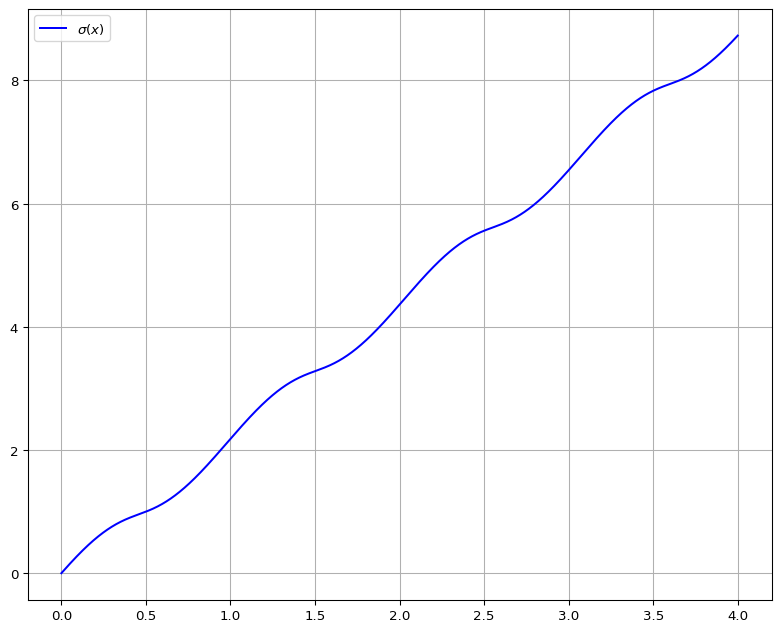

In [38]:
plt.figure(figsize=(10, 8), dpi=96)
ax = plt.subplot()
ax.plot(X, sigma, 'b-', label='$\sigma(x)$')
ax.legend()
# ax.set_xlim(0, 13)
ax.grid()
fig.supxlabel("Change of trajectory over X")
plt.show()

$t = \int{\frac{d\sigma}{v}}$\
$t = \sum{\frac{\sigma_i - \sigma_{i-1}}{v_i}}$

[0.00000000e+00 8.28153339e-04 1.65612501e-03 ... 6.15443060e+00
 6.15522328e+00 6.15601628e+00]


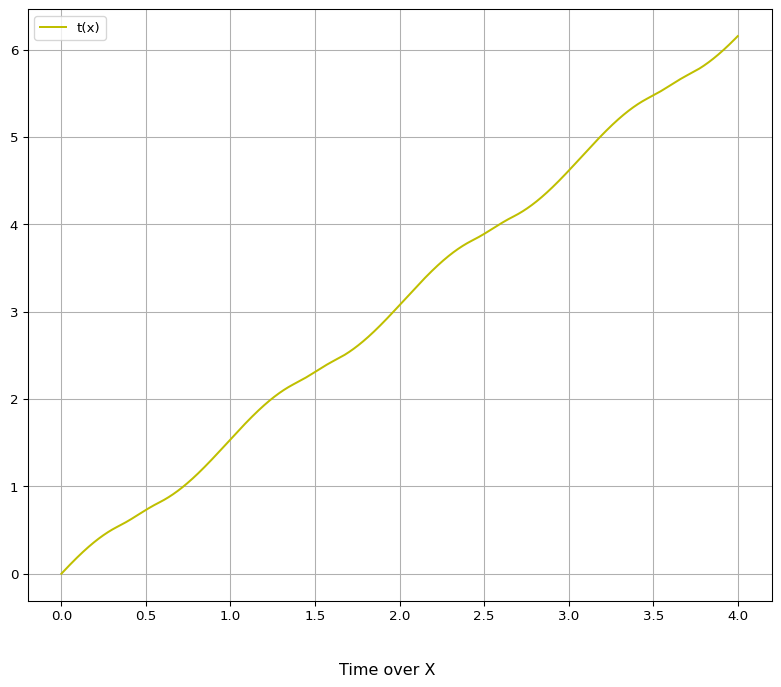

In [77]:
def find_time(distance: np.array, velocity: np.array):
    dtime = [0]
    time_linspace = [0]

    for i in range(1, N):
        ds = distance[i] - distance[i - 1]
        time_linspace = np.append(time_linspace, ds / velocity[i - 1] + time_linspace[-1])
        dtime = np.append(dtime, ds / velocity[i - 1])

    return dtime, time_linspace


dt, t_linspace = find_time(sigma, V)
print(t_linspace)
fig = plt.figure(figsize=(10, 8), dpi=96)
ax = plt.subplot()
ax.plot(X, t_linspace, 'y-', label='t(x)')
ax.legend()
ax.grid()
fig.supxlabel("Time over X")
plt.show()

# Step 3
Remember that the motors are real and to reach the velocities from the previous step, consider the formula $V = a_\tau * t$ or for the model I use, $V_i = a_\tau *t + V_{i-1}$ for the acceleration and deceleration phases.

Voila! Now u have the velocity and all u need.
### Plot all the graphs

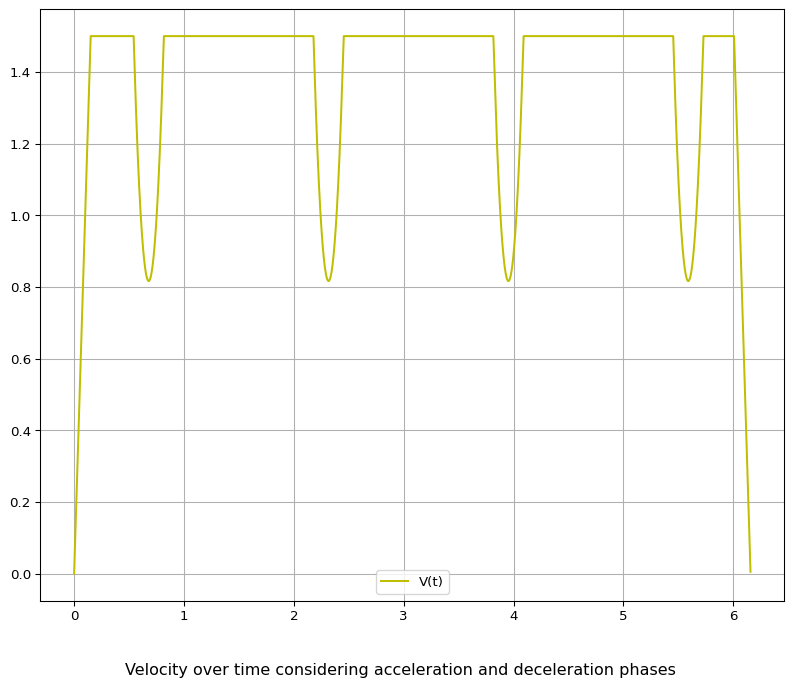

In [78]:
def clamp(n, smallest, largest):
    return max(smallest, min(n, largest))


def find_vel_with_acc_and_deceleration(time: np.array, velocity_from_normal_acceleration: np.array) -> Tuple[
    list, np.ndarray]:
    v = np.full(shape=time.shape, fill_value=0.0)
    a_n = np.full(shape=time.shape, fill_value=0.0)
    a_tan = np.full(shape=time.shape, fill_value=0.0)
    shouldStop = False

    for i in range(1, time.shape[0]):
        # Maximum velocity allowed by the normal acceleration. If we go past this, we go off the track.
        v_n_max = velocity_from_normal_acceleration[i]
        t = time[i]
        time_left = np.sum(time[i:])
        v_max = a_t_m * t + v[i - 1]

        shouldStop = shouldStop or v[i - 1] > a_t_m * time_left

        if shouldStop:
            # Period of final deceleration started. Just keep the brake fully pressed.
            v[i] = v[i - 1] - a_t_m * t
        else:
            v[i] = min(v_max, v_n_max)

        # Ensure acceleration does not go out of given bounds
        a_t = clamp((v[i] - v[i - 1]) / t, -a_t_m, a_t_m)
        # Update velocity according to the clamped acceleration
        v[i] = v[i - 1] + a_t * t
        a_n[i] = np.abs(v[i] ** 2 / R[i])
    return v, a_n

velocity, a_n_2 = find_vel_with_acc_and_deceleration(dt, V)
a_t = np.gradient(velocity, t_linspace)
fig = plt.figure(figsize=(10, 8), dpi=96)
ax = plt.subplot()
ax.plot(t_linspace, velocity, 'y-', label='V(t)')
ax.legend()
ax.grid()
fig.supxlabel("Velocity over time considering acceleration and deceleration phases")
plt.show()

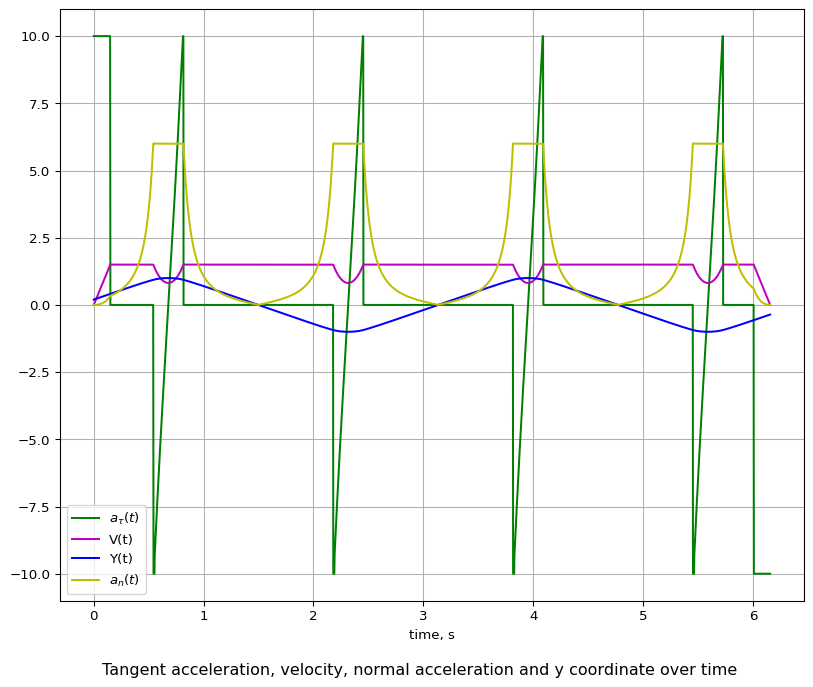

In [79]:
fig = plt.figure(figsize=(10, 8), dpi=96)
ax = plt.subplot()
ax.plot(t_linspace, a_t, 'g-', label='$a_\\tau(t)$')
ax.plot(t_linspace, velocity, 'm-', label='V(t)')
ax.plot(t_linspace, Y, 'b-', label='Y(t)')
ax.plot(t_linspace, a_n_2, 'y-', label='$a_n(t)$')
ax.legend()
ax.grid()
ax.set_xlabel('time, s')
fig.supxlabel("Tangent acceleration, velocity, normal acceleration and y coordinate over time")
plt.show()

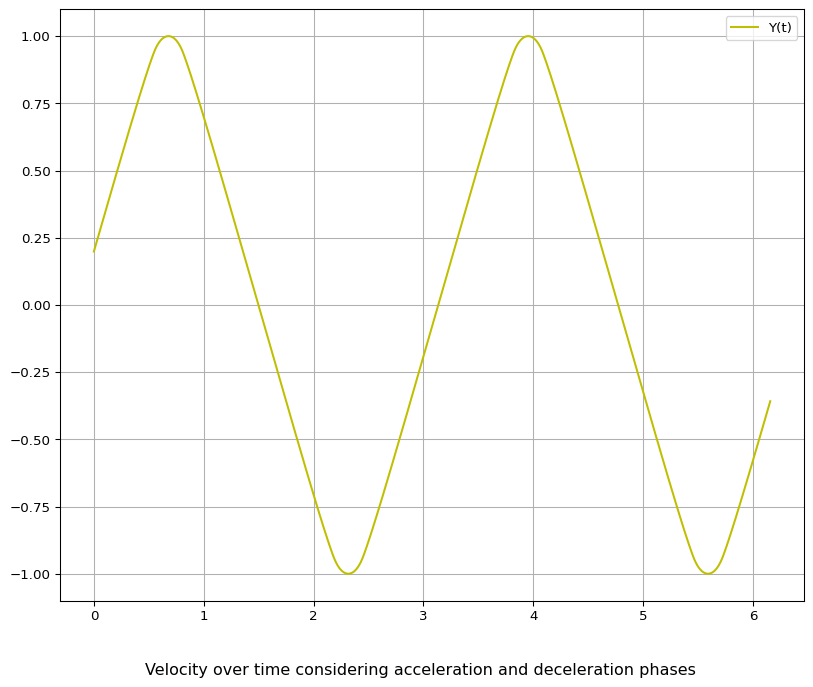

In [80]:
fig = plt.figure(figsize=(10, 8), dpi=96)
ax = plt.subplot()
ax.plot(t_linspace, Y, 'y-', label='Y(t)')
ax.legend()
ax.grid()
fig.supxlabel("Velocity over time considering acceleration and deceleration phases")
plt.show()
